# Image Classification with Logistic Regression

MNIST dataset handwritten image classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torch.optim import SGD

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset, random_split


In [2]:
mnist_train=MNIST(root='.', download=True, train=True)
mnist_test=MNIST(root='.', download=True, train=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
print(mnist_train[0][1])
mnist_train[0][0]

5





In [4]:
print(mnist_test[0][1])
mnist_test[0][0]

7


In [5]:
dataset=MNIST(root='.', download=True, train=True, transform=ToTensor())
testset=MNIST(root='.', download=True, train=False, transform=ToTensor())

In [6]:
dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
batch_size = 128
input_size=784
output_size=10
lr=0.001

In [8]:
len(dataset)

60000

In [9]:
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_data, batch_size=batch_size*2)
test_loader = DataLoader(testset, batch_size=batch_size*2)

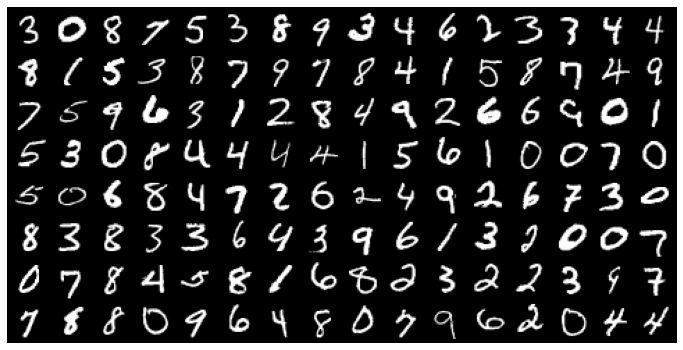

In [10]:
for images, labels in train_loader:
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [11]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
#         inputs = xb.unsqueeze(0)
        inputs=xb.reshape(-1, input_size)
        outputs = self.linear(inputs)
        return outputs
    
    def training_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = cross_entropy(outputs, targets)
        
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        outputs = self(inputs)
        loss = cross_entropy(outputs, targets)
        acc = accuracy(outputs, targets)
        
        return {'loss':loss.detach(), 'acc':acc.detach()}
    
    def validation_epoch_end(self, result):
        val_losses = [x['loss'] for x in result]
        val_loss = torch.stack(val_losses).mean()
        val_accs = [x['acc'] for x in result]
        val_acc = torch.stack(val_accs).mean()
        
        return {'loss': val_loss.item(), 'acc':val_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("ecpoch {} => val_loss: {}, val_acc: {}".format(epoch, result['loss'], result['acc']))

In [12]:
def accuracy(pred, target):
    maxvals, labels = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(labels == target).item()/len(pred))
    
def evaluate(model, val_loader):
    result_batches = [model.validation_step(batch) for batch in val_loader]
    val_avg_result = model.validation_epoch_end(result_batches)
    return val_avg_result

In [13]:
model= MNIST_Model()
evaluate(model, val_loader)

{'loss': 2.3327863216400146, 'acc': 0.10068359225988388}

In [14]:
def fit(model, epochs, batch_size, optim, lr, train_loader, val_loader):
    optim = optim(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optim.step()
            optim.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
history= fit(model, 10, batch_size, SGD, lr, train_loader, val_loader)

ecpoch 0 => val_loss: 1.96431565284729, val_acc: 0.578125
ecpoch 1 => val_loss: 1.6951360702514648, val_acc: 0.703125
ecpoch 2 => val_loss: 1.4938846826553345, val_acc: 0.7417968511581421
ecpoch 3 => val_loss: 1.3415777683258057, val_acc: 0.7679687738418579
ecpoch 4 => val_loss: 1.224261999130249, val_acc: 0.7831054925918579
ecpoch 5 => val_loss: 1.1318906545639038, val_acc: 0.793652355670929
ecpoch 6 => val_loss: 1.0575883388519287, val_acc: 0.80322265625
ecpoch 7 => val_loss: 0.9967488050460815, val_acc: 0.810253918170929
ecpoch 8 => val_loss: 0.9460393190383911, val_acc: 0.8153320550918579
ecpoch 9 => val_loss: 0.9030839800834656, val_acc: 0.822070300579071


In [16]:
pltloss=[x['loss'] for x in history]
pltacc=[x['acc'] for x in history]

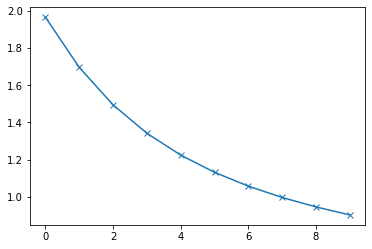

In [17]:
plt.plot(pltloss, '-x')
plt.show()

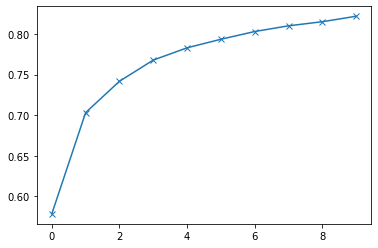

In [18]:
plt.plot(pltacc, '-x')
plt.show()

In [19]:
def predict(mode, inputs):
    img = inputs.unsqueeze(0)
    label = model(img)
    maxval, pred = torch.max(label, dim=1)
    return pred.item()

Target: 7, Prediction: 7


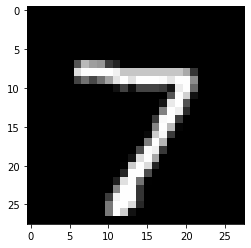

In [20]:
img, target = testset[0]
pred = predict(model, img)
print("Target: {}, Prediction: {}".format(target,pred))
plt.imshow(img[0], cmap='gray')
plt.show()

Target: 1, Prediction: 1


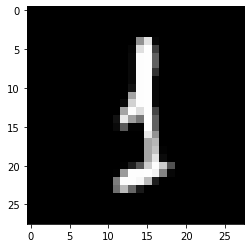

In [21]:
img, target = testset[900]
pred = predict(model, img)
print("Target: {}, Prediction: {}".format(target,pred))
plt.imshow(img[0], cmap='gray')
plt.show()

# Validation Loss and Accuracy on test set

In [22]:
evaluate(model, val_loader)

{'loss': 0.9030839800834656, 'acc': 0.822070300579071}

In [23]:
evaluate(model, test_loader)

{'loss': 0.8676315546035767, 'acc': 0.833984375}

1. Loss on **validation data** = 0.90 and accuracy = 82.63%
2. Loss on **test data** = 0.86 and accuracy = 83.46%